# Cmpe547 HW2

<IPython.core.display.Javascript object>


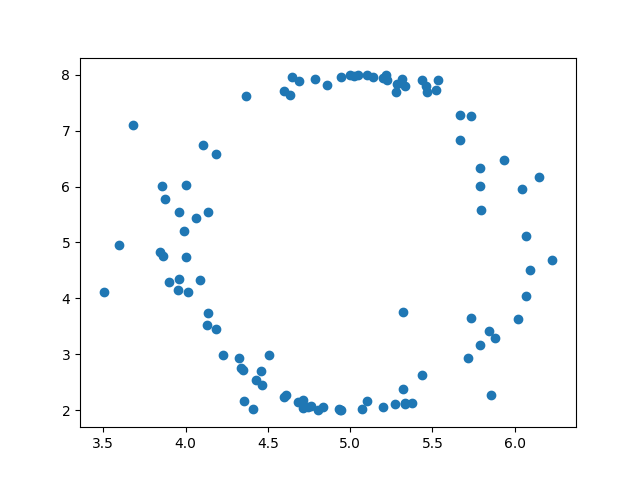

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

x = np.loadtxt('data', usecols=(0,1))
plt.scatter(x[:,0], x[:,1])
plt.show()

It looks like points were on the elips but shuffled along $x_1$ axis.
Therefore with the elips in the following form:
$$9(x_1-5)^2+(x_2-5)^2=9$$
and gaussian noise in the $x_1$ should give similar data set.

In [22]:
if np.random.uniform(low=0,high=1) > 0.5:
        up = 1
    else:
        up = -1
    return up*sqrt(9-9*(x-5)**2)+5

<IPython.core.display.Javascript object>


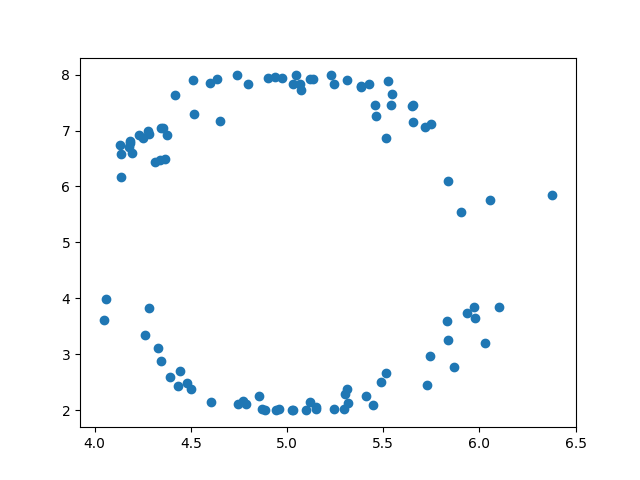

In [2]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

def model(x):
    if np.random.uniform(low=0,high=1) > 0.5:
        up = 1
    else:
        up = -1
    return up*sqrt(9-9*(x-5)**2)+5

sample = np.random.uniform(low=4, high=6, size=(100,))
plt.scatter([i-np.random.normal(0,0.15) for i in sample], [model(i) for i in sample])
plt.show()

We can divide the space into small segments and calculate the densities for each segment. The smaller difference in densities, the more similar data sets. 